### TODO
- I can't remember why this notebook is not in the src directory, try moving it there and see if it breaks anything...

In [10]:
import os
from pathlib import Path
import subprocess

from Bio.PDB.DSSP import make_dssp_dict
from Bio.Data.IUPACData import protein_letters_3to1
import pandas as pd

In [9]:
# Run DSSP on alphafold predicted structures
# Takes a while...
# The current version of DSSP (4.4.0) doesn't work with alphafold output because 
# it's missing some HEADER lines in the file, so add a dummy header.
# (see e.g. https://github.com/PDB-REDO/dssp/issues/54)
in_dir = Path('data/internal/alphafold/monomers')
out_dir = Path('data/processed/dssp_alphafold')
out_dir.mkdir(exist_ok=True)
for iso_dir in in_dir.iterdir():
    tmp_file = f'tmp_{iso_dir.stem}.pdb'
    out_file = out_dir / (iso_dir.stem + '.dssp')
    if out_file.exists():
        continue
    cmd_cat = f"cat dummy_PDB_header_to_get_dssp_to_work.pdb {iso_dir / 'ranked_0.pdb'} > {tmp_file}"
    subprocess.run(cmd_cat, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    cmd_dssp = f"mkdssp {tmp_file} {out_file}"
    ret = subprocess.run(cmd_dssp, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    os.remove(tmp_file)
    if ret.returncode != 0:
        print(cmd_dssp)
        print(ret.stderr)

mkdssp tmp.pdb data/processed/dssp_alphafold/ZNF451-3.dssp
b'Error parsing PDB at line 0\nEither the PDB file has no atom records, or the field END    is not at the correct location\n'
mkdssp tmp.pdb data/processed/dssp_alphafold/ZNF451-4.dssp
b'Error parsing PDB at line 0\nEither the PDB file has no atom records, or the field END    is not at the correct location\n'
mkdssp tmp.pdb data/processed/dssp_alphafold/ZNF131-1.dssp
b'Error parsing PDB at line 0\nEither the PDB file has no atom records, or the field END    is not at the correct location\n'
mkdssp tmp.pdb data/processed/dssp_alphafold/ZNF438-2.dssp
b'Error parsing PDB at line 0\nEither the PDB file has no atom records, or the field END    is not at the correct location\n'
mkdssp tmp.pdb data/processed/dssp_alphafold/ZNF277-1.dssp
b'Error parsing PDB at line 0\nEither the PDB file has no atom records, or the field END    is not at the correct location\n'
mkdssp tmp.pdb data/processed/dssp_alphafold/ZNF131-2.dssp
b'Error parsing 

In [13]:
dssp_dir = Path('data/processed/dssp_alphafold')
dfs = []
for dssp_file_path in dssp_dir.iterdir():
    dssp = make_dssp_dict(dssp_file_path)
    dfs.append(pd.DataFrame(data=[(dssp_file_path.stem, k[1][1], v[0], v[1], v[2]) for k, v in dssp[0].items()],
                      columns=['clone_name', 'position', 'aa', 'secondary_structure', 'ASA']))
df = pd.concat(dfs, axis=0, ignore_index=True)
# NOTE: the Davey analysis uses GGXGG whereas I think this paper is GXG
# Wilke: Tien et al. 2013 https://doi.org/10.1371/journal.pone.0080635
max_asa = {
        "ALA": 129.0,
        "ARG": 274.0,
        "ASN": 195.0,
        "ASP": 193.0,
        "CYS": 167.0,
        "GLN": 225.0,
        "GLU": 223.0,
        "GLY": 104.0,
        "HIS": 224.0,
        "ILE": 197.0,
        "LEU": 201.0,
        "LYS": 236.0,
        "MET": 224.0,
        "PHE": 240.0,
        "PRO": 159.0,
        "SER": 155.0,
        "THR": 172.0,
        "TRP": 285.0,
        "TYR": 263.0,
        "VAL": 174.0,
    }
max_asa = {protein_letters_3to1[k.capitalize()]: v for k, v in max_asa.items()}
df['RSA'] = df['ASA'] / df['aa'].map(max_asa)
df['RSA'] = df['RSA'].clip(upper=1.)
WINDOW_SIZE_RESIDUES = 20
DISORDER_WINDOW_RSA_CUTOFF = 0.5
rsa_window_col = f'RSA_window_{WINDOW_SIZE_RESIDUES}'
df[rsa_window_col] = (
         df.groupby('clone_name')['RSA']
           .rolling(window=WINDOW_SIZE_RESIDUES * 2 + 1,
                  min_periods=WINDOW_SIZE_RESIDUES + 1,
                  center=True)
             .mean().rename(rsa_window_col).droplevel('clone_name')
)
df['is_disordered'] = df[rsa_window_col] >= DISORDER_WINDOW_RSA_CUTOFF

# correct for long helices which are structured, usually bound to a partner
# but have high RSA in the monomer state
DISORDER_HELIX_LENGTH_CUTOFF = 20
to_change = []
for clone_name, df_clone in df.groupby('clone_name'):
    helix_count = 0
    for _i, row in df_clone.iterrows():
        if row['secondary_structure'] == 'H':
            helix_count += 1
        else:
            if helix_count >= DISORDER_HELIX_LENGTH_CUTOFF:
                for i in range(row['position'] - 1, row['position'] - helix_count, -1):
                    to_change.append((clone_name, i))
            helix_count = 0
    if helix_count >= DISORDER_HELIX_LENGTH_CUTOFF:
        for i in range(row['position'], row['position'] - helix_count, -1):
            to_change.append((clone_name, i))
to_change = (df['clone_name'] + '_' + df['position'].astype(str)).isin({a + '_' + str(b) for a, b in to_change})
print(f'{to_change.sum()} ({to_change.mean():.0%}) aa in helices of length 20 aa or more')
print(f"{df.loc[to_change, 'is_disordered'].mean():.0%} of residues in long helices misclassified as disordered")
df.loc[to_change, 'is_disordered'] = False

df.to_csv('data/processed/TFiso1_disorder-and-ss_from-alphafold.tsv',
          index=False, sep='\t')

In [23]:
import sys
sys.path.append('src')
from data_loading import load_annotated_TFiso1_collection

tfs = load_annotated_TFiso1_collection()

reading from cache


In [24]:
df.head()

,clone_name,position,aa,secondary_structure,ASA,RSA,RSA_window_20,is_disordered
0,RARB-2,1,M,-,214,0.955357,0.529437,True
1,RARB-2,2,I,-,158,0.802030,0.529412,True
2,RARB-2,3,Y,-,88,0.334601,0.515486,True
3,RARB-2,4,T,-,93,0.540698,0.496253,False
4,RARB-2,5,C,-,14,0.083832,0.489396,False


In [46]:
from matplotlib import pyplot as plt
from scipy import stats

In [31]:
df['is_cloned_reference'] = df['clone_name'].map({iso.name: iso.name == tf.cloned_reference_isoform.name
                                                  for tf in tfs.values() 
                                                  for iso in tf.cloned_isoforms})

clone_name
AEBP2-2      0.305970
AEBP2-3      0.665399
ARNT2-1      0.476987
ARNT2-2      0.461201
ARNT2-3      0.493017
               ...   
ZSCAN32-1    0.472023
ZSCAN32-2    0.453526
ZSCAN32-4    0.572093
ZSCAN9-1     0.347716
ZSCAN9-2     0.532567
Name: is_disordered, Length: 686, dtype: float64

In [54]:
import numpy as np
import tqdm

0.5669291338582677 0.5 0.06692913385826771


100%|██████████| 9999/9999 [01:21<00:00, 122.49it/s]


p = 0.0042004200420042
MannwhitneyuResult(statistic=58903.5, pvalue=0.040780620312842936)


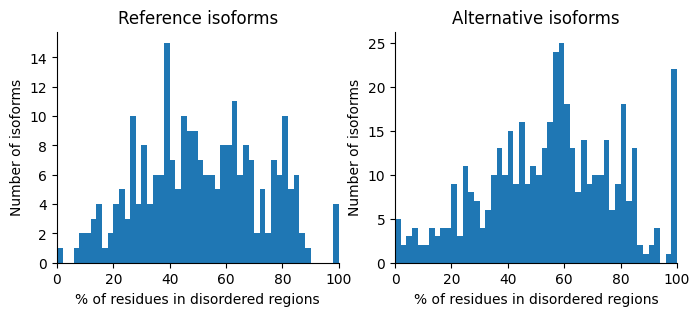

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=8, h=3)
f_dis_ref = df.loc[df['is_cloned_reference']].groupby('clone_name')['is_disordered'].mean()
f_dis_alt = df.loc[~df['is_cloned_reference']].groupby('clone_name')['is_disordered'].mean()

# randomization p-value
obs_val = f_dis_alt.median() - f_dis_ref.median()
print(f_dis_alt.median(), f_dis_ref.median(), obs_val)
rnd_vals = []
gene_to_isoforms = {tf.name: [iso.name for iso in tf.cloned_isoforms] for tf in tfs.values()}
np.random.seed(34298793)
for _i in tqdm.tqdm(range(1, 10000)):
    all_vals = df.groupby('clone_name')['is_disordered'].mean()
    rnd_refs = set()
    for isoforms in gene_to_isoforms.values():
        rnd_refs.add(np.random.choice(isoforms))
    rnd_vals.append(all_vals.loc[~all_vals.index.isin(rnd_refs)].median()
                    -
                    all_vals.loc[all_vals.index.isin(rnd_refs)].median())
pval = sum(rnd_val >= obs_val for rnd_val in rnd_vals) / len(rnd_vals) * 2
print(f'p = {pval}')


axs[0].hist(f_dis_ref * 100, range=(0, 100), bins=50)
axs[1].hist(f_dis_alt * 100, range=(0, 100), bins=50)
axs[0].set_title('Reference isoforms')
axs[1].set_title('Alternative isoforms')
for ax in axs.flatten():
    ax.set_xlim(0, 100)
    ax.set_xlabel('% of residues in disordered regions')
    ax.set_ylabel('Number of isoforms')
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
fig.savefig('figures/disordered-residued-pct-per-isoform_TFiso1_histogram.pdf', bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: P = 0.004


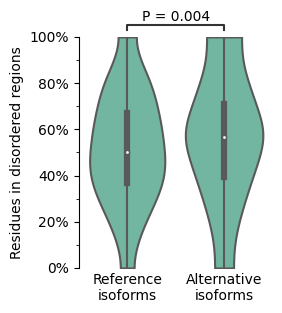

In [100]:
import seaborn as sns
from statannotations.Annotator import Annotator

from plotting import violinplot_reflected

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2.5, h=3)
data = (df.groupby(['clone_name', 'is_cloned_reference'])
                            ['is_disordered']
                            .mean()
                            .reset_index())
violinplot_reflected(data=data,
                     x='is_cloned_reference',
                     y='is_disordered',
                     order=[True, False],
                     cut=0,
                     color=sns.color_palette("Set2")[0],
                     )
ax.set_ylim(0, 1)
ax.set_ylabel('Residues in disordered regions')
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
ax.set_xlabel('')
ax.set_xticklabels(['Reference\nisoforms', 'Alternative\nisoforms'])
for loc in ['top', 'right', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)


annotator = Annotator(ax=ax, 
                    pairs=[(True, False)],
                    data=data,
                     x='is_cloned_reference',
                     y='is_disordered',
                    order=[True, False],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.3f}'.format(pval)])

fig.savefig('figures/disordered-residued-pct-per-isoform_TFiso1_violin.pdf',
            bbox_inches=False)

In [91]:
np.linspace(0, 1,6)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

Text(0, 0.5, '% residues in disordered regions')

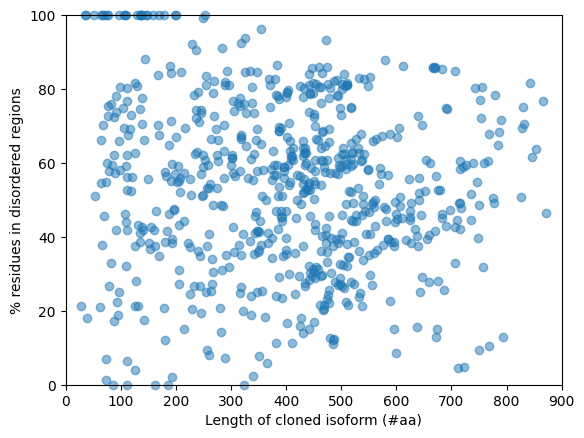

In [18]:
# TODO: color by family
# TODO: split by reference and alternative isoforms
fig, ax = plt.subplots(1, 1)
ax.scatter(df.groupby('clone_name').size(), 
           df.groupby('clone_name')['is_disordered'].mean() * 100,
           clip_on=False,
           alpha=0.5)
ax.set_ylim(0, 100)
ax.set_xlim(0, 900)
ax.set_xlabel('Length of cloned isoform (#aa)')
ax.set_ylabel('% residues in disordered regions')

In [ ]:
# plots of length of disordered sequence?

In [ ]:
# comparison of reference to alternative isoforms


In [ ]:
# pairwise metrics of disorder/order
# - number of ordered residues different
# - number of disordered residues different

In [75]:
# lazy version: delta disordered residues
# for each isoform: number of residues, disordered residues and ordered residues
# for each pair, delta of all
n_aa = df.groupby('clone_name').size().rename('n_aa').to_frame()
n_aa['n_aa_disordered'] = df.groupby('clone_name')['is_disordered'].sum()
n_aa['n_aa_ordered'] = n_aa['n_aa'] - n_aa['n_aa_disordered']

In [129]:
f_dis.sort_values()

clone_name
ZNF415-4    0.0
ZNF415-3    0.0
TBPL1-1     0.0
ZBTB25-4    0.0
KLF7-6      0.0
           ... 
ZNF696-2    1.0
ZNF23-3     1.0
ZNF175-3    1.0
ZNF772-4    1.0
DLX5-2      1.0
Name: is_disordered, Length: 742, dtype: float64